<a href="https://www.kaggle.com/code/andrejeronimaguerra/ames-iowa-predict-house-sale-prices?scriptVersionId=211382990" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Key points about this competition:

**1.Objective:** 
* Predict house sale prices in Ames, Iowa using 79 different features

**2. Evaluation Metric:**
* Root-Mean-Squared-Error (RMSE) on the logarithm of predicted vs. actual prices
* Using log prices means errors on expensive and cheap houses affect the score equally

**3.Key Skills to Practice:**
* Feature engineering
* Advanced regression techniques (Random Forests, Gradient Boosting)
* Handling missing data and categorical variables**

**4. Starter code package:**
* Data analysis function to examine missing values, correlations, and distributions
* Feature preparation function to handle missing values and encode categorical variables
* Model evaluation function that implements the competition's scoring metric

# Let's get started:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# ===============================
# 1. LOAD DATA
# ===============================

In [2]:
print("\n1. Loading data...")
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


1. Loading data...
Training data shape: (1460, 81)
Test data shape: (1459, 80)


# ===============================
# 2. DATA VISUALIZATION
# ===============================


2. Creating visualizations...


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


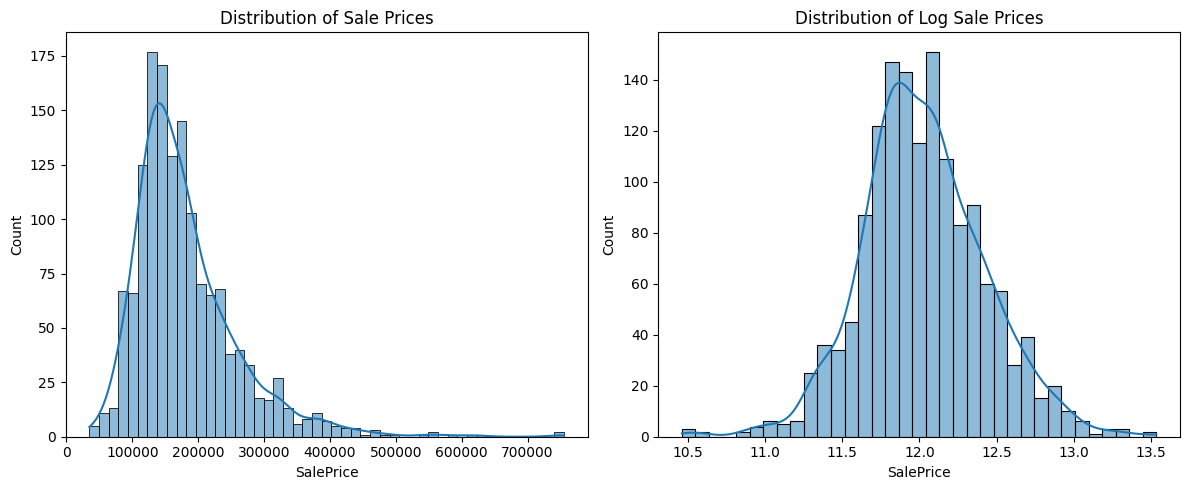

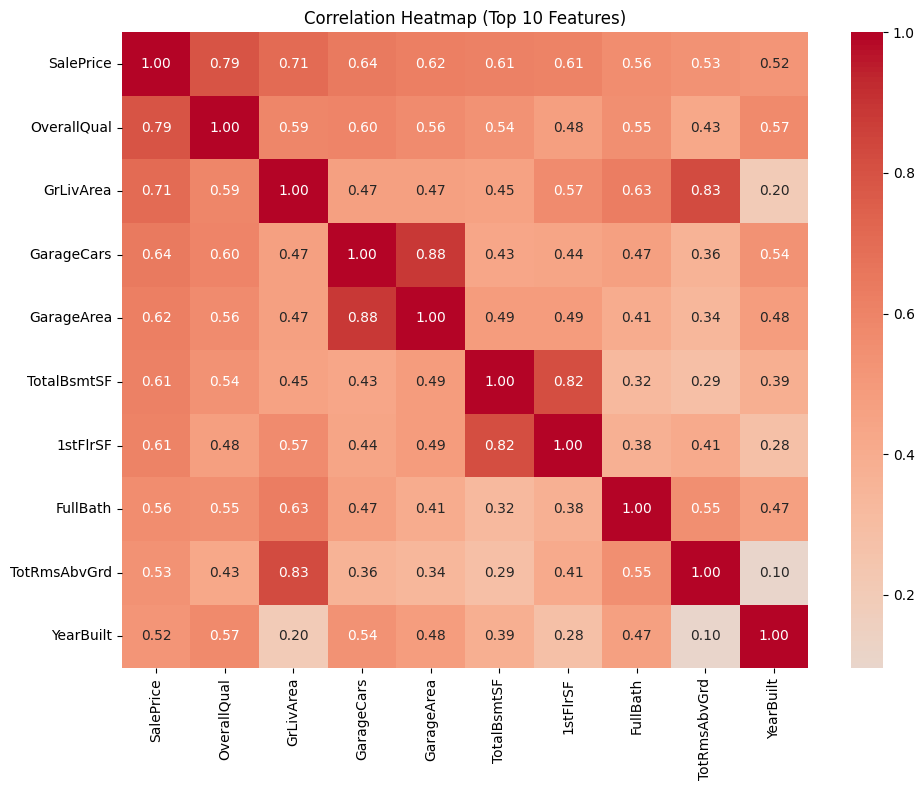

In [3]:
print("\n2. Creating visualizations...")

# Plot price distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_data['SalePrice']), kde=True)
plt.title('Distribution of Log Sale Prices')
plt.tight_layout()
plt.show()

# Plot correlation heatmap
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
correlations = train_data[numeric_cols].corr()
most_correlated = correlations['SalePrice'].abs().sort_values(ascending=False)[:10].index

plt.figure(figsize=(10, 8))
sns.heatmap(correlations.loc[most_correlated, most_correlated], 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Correlation Heatmap (Top 10 Features)')
plt.tight_layout()
plt.show()

In [4]:
# ===============================
# 3. HANDLE MISSING VALUES
# ===============================

In [5]:
print("\n3. Handling missing values...")

# Process training data
train_cleaned = train_data.copy()
test_cleaned = test_data.copy()

# For both training and test data
for dataset in [train_cleaned, test_cleaned]:
    # Numeric columns: fill with median
    numeric_features = dataset.select_dtypes(include=[np.number]).columns
    for col in numeric_features:
        dataset[col].fillna(dataset[col].median(), inplace=True)
    
    # Categorical columns: fill with mode
    categorical_features = dataset.select_dtypes(include=['object']).columns
    for col in categorical_features:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)


3. Handling missing values...


/tmp/ipykernel_17/3657918701.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].median(), inplace=True)
/tmp/ipykernel_17/3657918701.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

# ===============================
# 4. FEATURE ENGINEERING
# ===============================

In [6]:
print("\n4. Creating new features...")

# Create area interactions for both datasets
for dataset in [train_cleaned, test_cleaned]:
    # Area interactions
    dataset['Total_Area'] = dataset['GrLivArea'] + dataset.get('TotalBsmtSF', 0)
    dataset['Area_Quality'] = dataset['GrLivArea'] * dataset['OverallQual']
    
    # Age of house at sale
    dataset['House_Age'] = dataset['YrSold'] - dataset['YearBuilt']
    dataset['Remod_Age'] = dataset['YrSold'] - dataset['YearRemodAdd']


4. Creating new features...


# ===============================
# 5. PREPARE FEATURES
# ===============================

In [7]:
print("\n5. Preparing features for modeling...")

# Convert categorical variables to dummy variables
train_prepared = pd.get_dummies(train_cleaned)
test_prepared = pd.get_dummies(test_cleaned)

# Align training and test data columns
common_columns = [col for col in train_prepared.columns if col in test_prepared.columns]
train_prepared = train_prepared[common_columns]
test_prepared = test_prepared[common_columns]

# Scale numeric features
scaler = StandardScaler()
numeric_cols = train_prepared.select_dtypes(include=[np.number]).columns
train_prepared[numeric_cols] = scaler.fit_transform(train_prepared[numeric_cols])
test_prepared[numeric_cols] = scaler.transform(test_prepared[numeric_cols])

# Prepare X and y for training
X = train_prepared.drop(['SalePrice', 'Id'], axis=1, errors='ignore')
y = np.log1p(train_data['SalePrice'])  # Log transform target
X_test = test_prepared.drop('Id', axis=1, errors='ignore')


5. Preparing features for modeling...


# ===============================
# 6. TRAIN MODELS
# ===============================

In [8]:
print("\n6. Training multiple models...")

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
model_predictions = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    # Store predictions
    model_predictions[name] = model.predict(X_test)
    
    print(f"{name} Validation RMSE: {val_rmse:.4f}")


6. Training multiple models...

Training Linear Regression...
Linear Regression Validation RMSE: 68174408.5580

Training Ridge...
Ridge Validation RMSE: 0.1337

Training Random Forest...
Random Forest Validation RMSE: 0.1465

Training Gradient Boosting...
Gradient Boosting Validation RMSE: 0.1400

Training XGBoost...
XGBoost Validation RMSE: 0.1478


# ===============================
# 7. CREATE ENSEMBLE PREDICTIONS
# ===============================

In [9]:
print("\n7. Creating ensemble predictions...")

# Average predictions from all models
final_predictions = np.mean([pred for pred in model_predictions.values()], axis=0)

# Transform predictions back from log scale
final_predictions = np.expm1(final_predictions)


7. Creating ensemble predictions...


/tmp/ipykernel_17/1001164388.py:7: RuntimeWarning: overflow encountered in expm1
  final_predictions = np.expm1(final_predictions)


# ===============================
# 8. CREATE SUBMISSION FILE
# ===============================

In [10]:
print("\n8. Creating submission file...")

submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created! Ready to submit to Kaggle.")


8. Creating submission file...

Submission file created! Ready to submit to Kaggle.


# ===============================
# 9. FEATURE IMPORTANCE PLOT
# ===============================


9. Plotting feature importance...


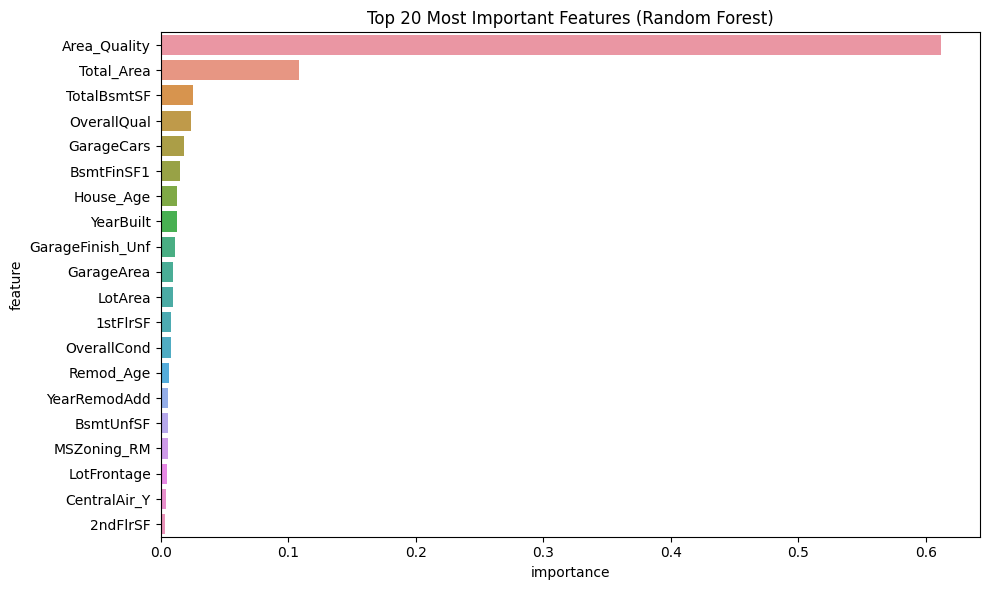

In [11]:
print("\n9. Plotting feature importance...")

# Get feature importance from Random Forest model
rf_model = models['Random Forest']
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()